## Warngling process table
### 1. [Gathering Data](#g_data)
### 2. [Assessing Data](#assess)
### 3. [Cleaning Data](#clean)
### 4. [Storing](#store)
### 5. [Data Analysis and Visualizations](#analysis)

In [390]:
import pandas as pd
import requests
import os
import tweepy
import json
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt

## Gathering data 
<a id="g_data"></a>

In [391]:
# read tiwtter archive to df
archive_df = pd.read_csv("twitter-archive-enhanced.csv")



#download images_NL file and open as df

url= "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(url)

if not os.path.isfile(url.split("/")[-1]):
    with open(url.split("/")[-1], mode="wb") as f:
        f.write(r.content)
image_p_df = pd.read_csv(url.split("/")[-1], sep="\t")


###twitter api#####
'''consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
'''
#################

#import data from tweet-json file to df that consists of favorit_count&retweet_count&tweet id 

rt=[]
favb=[]
i_d=[]

with open("tweet-json","r") as file:
    
    for l in file:
        to_dic = json.loads(l)
        rt.append(to_dic['retweet_count'])
        favb.append(to_dic['favorite_count'])
        i_d.append(to_dic['id'])
        
        

json_df =pd.DataFrame({
    "tweet_id":i_d,
    "retweet_count":rt,
    "fav_count":favb
})

## Assessing data
<a id="assess"></a>

## Quality issues
### - `Combleteness`
    - missing(NaN) values in columns (in_reply_to_status_id,in_reply_to_user_id) and breed types
    - missing values in name column that can get it from text
    - tweets with no images
    - datasets have retweets and replys data not only tweets
    
### - `Validity`
    - not valid names (the, a, an, by)
    - there are tweets with out images (expanded_urls and retweet url          are empty)
    - there are retweets in all datasets in this data (
      retweeted_status_id           181 non-null float64
      retweeted_status_user_id      181 non-null float64
      retweeted_status_timestamp    181 non-null object )
      
    - there are replys in all datasets in this data (
      in_reply_to_status_id           78 non-null float64
      in_reply_to_user_id      78 non-null float64 )
    - rating_numenator col doesn't match with rate in text (ex: index 47) and there is outliers
    - denominator not equal 10 (ex: index 435)

### - `Accuracy`
    - name values don't match with names in text
    - rating_numenator col doesn't match with rate in text (ex: index 47) and there is outliers
    - source column is an HTML tag


### - `Consistency`
    -	tweet_id dtype is int
    -	unused columns like (denominator, expanded_urls, retweeted_status_id, retweeted_status_user_id, in_reply_to_status_id, in_reply_to_user_id) 
    -	unused columns like img_num and p_n_prediction in image_p df

    

      
      
## - Tideness issues

    - values are column names in archive_df (ex: doggo, floofer, pupper, puppo  should be combined into a single column as this is one variable that identify type of dog)

    - values are column names in image_p_df (ex: p1, p1_dog, p1_conf. p2, p2_dog,p2_conf,p3,p3_dog,p3_conf  all these columns should be in only three columns )

    - Information about one type of observational unit (tweets) is spread across three different DataFrames. So these three DataFrames should be merged as they are part of the same observational unit.

      


In [392]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [393]:
#tweets that have no images
archive_df[archive_df["expanded_urls"].isna()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [394]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [395]:
image_p_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [396]:
image_p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [397]:
json_df.head()

,tweet_id,retweet_count,fav_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [398]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id         2354 non-null int64
retweet_count    2354 non-null int64
fav_count        2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


## Cleaning data
<a id="clean"></a>

 ### `Define`
 
 - remove retweets, replys and expanded_urls from all datasets
 - drop columns:
     -  expanded_urls,
     -  in_reply_to_status_id,
     -  in_reply_to_user_id,
     -  retweeted_status_timestamp,
     -  retweeted_status_user_id,
     -  retweeted_status_id
     

### `Code`

In [399]:
# copy all datasets
clean_archive = archive_df.copy()
clean_image_p = image_p_df.copy()
clean_json = json_df.copy()


#drop tweets that with no images
clean_archive = clean_archive[~clean_archive["expanded_urls"].isna()]

# creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(clean_image_p.tweet_id.unique())

# Cleaning in action ;)
clean_archive = clean_archive[clean_archive.tweet_id.isin(tweets_with_image)]


#get retweets
retweets_l = clean_archive.retweeted_status_id.notnull()

#drop retweets observations
clean_archive = clean_archive[~retweets_l]

#get replys
replys_l = clean_archive.in_reply_to_status_id.notnull()

#drop replys observations
clean_archive = clean_archive[~replys_l]


# Dropping the retweets and replies ids from the image prediction dataframe
clean_image_p = clean_image_p[~np.logical_not(clean_image_p.tweet_id.isin(list(clean_archive.tweet_id)))]

# Dropping the retweets and replies ids from json dataframe
clean_json = clean_json[~np.logical_not(clean_json.tweet_id.isin(list(clean_archive.tweet_id)))]

#Dropping reply and tweet columns 
clean_archive = clean_archive.drop(['retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp',\
                                   "in_reply_to_status_id","in_reply_to_user_id","expanded_urls"],axis=1)







### `Test`

In [400]:
clean_archive.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


### `Define`
- fix breeds' name by making one new col and drop remain 4 cols


### `Code`

In [401]:
# select the dog stages columns from the dataset
breeds = ['doggo', 'pupper', 'puppo', 'floofer']
# replace the 'None' string with np.nan 
for i in breeds:
    if i in clean_archive.columns:
        clean_archive[breeds] = clean_archive[breeds].replace('None', np.nan)

        # create the type column with joining the four columns in one column dog_stage join for more than stage
        clean_archive['type'] = clean_archive[breeds].apply(lambda x: ', '.join(x.dropna().astype('str')),axis =1)
        # replace the empty string with nan and change datatype to category
        clean_archive.type = clean_archive.type.replace('', np.nan)

        # drop the 4 columns

        clean_archive = clean_archive.drop(columns = breeds, axis =1)
clean_archive.loc[200, "type"] = "floofer"
clean_archive.loc[clean_archive[clean_archive.type == "doggo, puppo"].index,"type"] = "puppo"


### `Test`

In [402]:
clean_archive.type.value_counts()

pupper           201
doggo             63
puppo             23
floofer            8
doggo, pupper      8
Name: type, dtype: int64

### `Define`
#### change name col values
    - get untitled names in clean_archive df then assign that name to "NaN"
    - get lower names in clean_archive df then assign that name to "NaN"

### `code`

In [403]:
# get untitled an lower names from archive df 
untitled = clean_archive.name.loc[clean_archive.name.str.istitle() == False].unique()
lowers = clean_archive.name.loc[clean_archive.name.str.islower()].unique()

l = np.concatenate((untitled,lowers),axis=0)
l = np.unique(l).tolist()[5:]
clean_archive.loc[clean_archive.name.apply(lambda x: x in l), "name"] = np.nan
clean_archive.loc[clean_archive[clean_archive.name == "None"].index,"name"] = np.nan


### `Test`

In [404]:
clean_archive.sample()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type
2172,669327207240699904,2015-11-25 01:30:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Just got home from college. Dis my dog. She do...,13,10,NaN,NaN


### Define
- extract name from text


### `Code`

In [405]:
clean_archive["name"] = clean_archive.text.str.extract('((This is|Meet) ([A-Z][a-z]*)\\.)', expand=True)[2]


### `Test`

In [406]:
clean_archive.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type
1748,679062614270468097,2015-12-21 22:15:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chompsky. He lives up to his name. 11/...,11,10,Chompsky,NaN
2053,671485057807351808,2015-12-01 00:24:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Penelope. She is a white Macadamias Duode...,11,10,Penelope,NaN
797,773191612633579521,2016-09-06 16:10:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Grey. He's the dogtor in charge of you...,12,10,Grey,NaN
1500,692158366030913536,2016-01-27 01:33:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Edgar. He's a Sassafras Puggleflash. N...,10,10,Edgar,NaN
76,878057613040115712,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,14,10,Emmy,NaN


In [407]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null object
source                1971 non-null object
text                  1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1178 non-null object
type                  303 non-null object
dtypes: int64(3), object(5)
memory usage: 218.6+ KB


### `Define`
- extract rating_numerator and rating_denominator if a rating_denominator is more than 10
- deal with rate

### `Code`

In [408]:
# get indexes and extract dog rate from text that its rating_numerator is more than 20 which should be have more than
# one dog
rate = clean_archive[clean_archive["rating_numerator"] > 20 ].text.str.extract('(\d+[.]{1}\d+[/]\d+|(\d+[/]\d+))')[0].tolist()
de = clean_archive[clean_archive["rating_numerator"] > 20 ].text.str.extract('(\d+[.]{1}\d+[/]\d+|(\d+[/]\d+))')[0].index

In [409]:
# only fix index 1068 manually
clean_archive.loc[1068, "rating_numerator"] = 14
clean_archive.loc[1068, "rating_denominator"] = 10

# change dtype of rating_denominator and rating_numerator
clean_archive.rating_numerator = clean_archive.rating_numerator.astype("float64")
clean_archive.rating_denominator = clean_archive.rating_denominator.astype("float64")
clean_archive.rating_numerator.loc[1068]

# set all rating_denominator values to 10
clean_archive.rating_denominator = 10

# fix indexes values from previous list de
for i,j in zip(de, rate):
    if clean_archive.loc[i, "rating_numerator"] >10:
        clean_archive.loc[i, "rating_numerator"] = round(( float(j.split('/')[0]) / ( float(j.split('/')[1]) / 10)), 1)
    clean_archive.loc[i, "rating_denominator"] = 10.0



### `Test`

In [410]:
# test gathered rate
clean_archive.loc[de]

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type
433,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,12.0,10.0,NaN,NaN
516,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,34.3,10.0,Sam,NaN
695,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",9.8,10.0,NaN,NaN
763,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,11.3,10.0,Sophie,pupper
902,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,11.0,10.0,NaN,NaN
979,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,1776.0,10.0,Atticus,NaN
1120,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,12.0,10.0,NaN,NaN
1202,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,10.0,10.0,Bluebert,NaN
1228,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,11.0,10.0,NaN,NaN
1254,710658690886586372,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,10.0,10.0,NaN,NaN


In [411]:
clean_archive.rating_numerator.value_counts()

12.0      450
10.0      419
11.0      397
13.0      253
9.0       150
8.0        95
7.0        52
14.0       34
5.0        33
6.0        32
3.0        19
4.0        16
2.0         9
1.0         5
11.3        2
9.8         1
0.0         1
1776.0      1
420.0       1
34.3        1
Name: rating_numerator, dtype: int64

In [412]:
clean_image_p.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### `Define`
- fix source col in clean_archive df

### `Code`

In [413]:
clean_archive.source = clean_archive.source.str.extract(r'(?!for\b)([^>]*([A-Z])\w+)')[0]


### `Test`

In [414]:
clean_archive.source.value_counts()

Twitter for iPhone    1932
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

### Define 
- rename cols in clean_image_p df

### `Code`

In [415]:
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
clean_image_p.columns = cols


### `Test`

In [416]:
clean_image_p.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,breed_1,prediction_2,confidence_2,breed_2,prediction_3,confidence_3,breed_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Define 
- get breed name and confidence from clean_image_p df to avoid values in headers issue 

### `Code`

In [417]:
#run one time
conf = []
bree = []
idd = []
tmp = pd.DataFrame()
def get_conf_breed(data):
    
    if data.breed_1:
        conf.append(data.confidence_1)
        bree.append(data.prediction_1)
        idd.append(data.tweet_id)
    
    elif data.breed_2:
        conf.append(data.confidence_2)
        bree.append(data.prediction_2)
        idd.append(data.tweet_id)
    
    elif data.breed_3:
        conf.append(data.confidence_3)
        bree.append(data.prediction_3)
        idd.append(data.tweet_id)
        
    else:
        conf.append(0)
        bree.append(np.nan)
        idd.append(data.tweet_id)


clean_image_p.apply(get_conf_breed, axis=1)
        
tmp["tweet_id"]= idd
tmp["breed"] = bree
tmp["prediction_conf"] = conf



    
   

### `Test`

In [418]:
# tmp df is clean data from clean_image_p df predictions
tmp.head()

,tweet_id,breed,prediction_conf
0,666020888022790149,Welsh_springer_spaniel,0.465074
1,666029285002620928,redbone,0.506826
2,666033412701032449,German_shepherd,0.596461
3,666044226329800704,Rhodesian_ridgeback,0.408143
4,666049248165822465,miniature_pinscher,0.560311


### Define
- drop unimportant cols in clean_image_p df and merge tmp df instead

### `Code`

In [419]:
clean_image_p = clean_image_p.drop(["prediction_1", "confidence_1", "breed_1","prediction_2", "confidence_2", "breed_2", "prediction_3",\
           "confidence_3", "breed_3"],axis=1)

clean_image_p = pd.merge(clean_image_p,tmp, on="tweet_id")


### `Test`

In [420]:
clean_image_p.head()

,tweet_id,jpg_url,img_num,breed,prediction_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


### Define 
- merge clean_image_p and clean_json and clean_archive df in twitter_archive_master df

### `Code`

In [421]:
twitter_archive_master = pd.merge(clean_archive, clean_image_p, on="tweet_id")
twitter_archive_master = pd.merge(twitter_archive_master, clean_json, on="tweet_id")


### `Test`

In [422]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type,jpg_url,img_num,breed,prediction_conf,retweet_count,fav_count
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,NaN,0.000000,8853,39467
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,6514,33819
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,4328,25461
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever,0.168086,8964,42908
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,9774,41048


### `Define`
- **drop the row that has sentence "We only rate dogs" this tweet's image doesn't include dogs**


### `Code`

In [423]:
twitter_archive_master.drop(\
  twitter_archive_master[twitter_archive_master.text.apply(lambda x: "We only rate dogs" in x)].index,axis=0,inplace=True)

### `Test`

In [424]:
#insure that non-dogs tweets is removed
twitter_archive_master[twitter_archive_master.text.apply(lambda x: "We only rate dogs" in x)].index

Int64Index([], dtype='int64')

### Define
- replace None values to Nan in type and name columns

### `Code`

In [425]:
twitter_archive_master.type = twitter_archive_master.type.replace(to_replace = "None", value=np.nan)
twitter_archive_master.name = twitter_archive_master.name.replace(to_replace = "None", value=np.nan)

### `Test`

In [426]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type,jpg_url,img_num,breed,prediction_conf,retweet_count,fav_count
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,NaN,0.000000,8853,39467
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,6514,33819
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,4328,25461
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever,0.168086,8964,42908
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,9774,41048


### Define 
- drop rating_denominator col from twitter_archive_master it's a known fixed number
- drop img_num col from twitter_archive_master not needed in analysis

### `Code` 

In [427]:
twitter_archive_master = twitter_archive_master.drop(["rating_denominator","img_num"], axis=1)


In [428]:
twitter_archive_master = twitter_archive_master.reset_index()
twitter_archive_master = twitter_archive_master.drop("index",axis=1)

### `Test`

In [429]:
twitter_archive_master.sample()

,tweet_id,timestamp,source,text,rating_numerator,name,type,jpg_url,breed,prediction_conf,retweet_count,fav_count
161,849412302885593088,2017-04-05 00:04:08 +0000,Twitter for iPhone,This is Noosh. He noticed you were in the show...,12.0,Noosh,NaN,https://pbs.twimg.com/media/C8m3-iQVoAAETnF.jpg,schipperke,0.907559,3487,17039


### Define
- remove a row has no name&type&breed & numerator >100 (ex: twitter_archive_master.rating_numerator == 420.0 not a dog)

### `Code`

In [430]:
x = twitter_archive_master.apply(\
lambda x:  (x["rating_numerator"] > 100) & (pd.isnull(x["breed"])) & (pd.isnull(x["name"])) & (pd.isnull(x["type"])),axis=1)

twitter_archive_master.drop(twitter_archive_master[x].index,axis=0, inplace=True)

### `Test`

In [431]:
twitter_archive_master.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,name,type,jpg_url,breed,prediction_conf,retweet_count,fav_count
1207,686947101016735744,2016-01-12 16:25:26 +0000,Twitter for iPhone,This is Jackson. He was specifically told not ...,11.0,Jackson,NaN,https://pbs.twimg.com/media/CYiGvn-UwAEe4wL.jpg,NaN,0.000000,3582,9433
1047,699801817392291840,2016-02-17 03:45:29 +0000,Twitter for iPhone,This is Cooper. He began to tear up when his b...,11.0,Cooper,pupper,https://pbs.twimg.com/media/CbYyCMcWIAAHHjF.jpg,golden_retriever,0.808978,1088,3345
1199,687460506001633280,2016-01-14 02:25:31 +0000,Twitter for iPhone,This is Kramer. He's a Picasso Tortellini. Tie...,10.0,Kramer,NaN,https://pbs.twimg.com/media/CYpZrtDWwAE8Kpw.jpg,Boston_bull,0.223366,614,2243
882,717009362452090881,2016-04-04 15:22:08 +0000,Twitter for iPhone,This is Smokey. He's having some sort of exist...,10.0,Smokey,pupper,https://pbs.twimg.com/media/CfNUNetW8AAekHx.jpg,Siberian_husky,0.506154,1102,3583
440,793256262322548741,2016-11-01 01:00:05 +0000,Twitter for iPhone,Oh h*ck look at this spookling right here. Fri...,12.0,NaN,NaN,https://pbs.twimg.com/media/CwI2XCvXEAEO8mc.jpg,basset,0.207622,9714,22350


In [432]:
# row has no name&type&breed & numerator >100 and not a dog
twitter_archive_master[twitter_archive_master.rating_numerator == 420.0]

,tweet_id,timestamp,source,text,rating_numerator,name,type,jpg_url,breed,prediction_conf,retweet_count,fav_count


### Define 
- change tweet id dtype to 

### `Code`

In [433]:
twitter_archive_master.tweet_id = twitter_archive_master.astype({'tweet_id': 'object'})

### `Test`

In [434]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1922 entries, 0 to 1922
Data columns (total 12 columns):
tweet_id            1922 non-null object
timestamp           1922 non-null object
source              1922 non-null object
text                1922 non-null object
rating_numerator    1922 non-null float64
name                1178 non-null object
type                303 non-null object
jpg_url             1922 non-null object
breed               1622 non-null object
prediction_conf     1922 non-null float64
retweet_count       1922 non-null int64
fav_count           1922 non-null int64
dtypes: float64(2), int64(2), object(8)
memory usage: 195.2+ KB


### Define
- reset index in twitter_archive_master df

### `Code`

In [435]:
twitter_archive_master = twitter_archive_master.reset_index()
twitter_archive_master = twitter_archive_master.drop("index",axis=1)

### `Test`

In [436]:
twitter_archive_master

,tweet_id,timestamp,source,text,rating_numerator,name,type,jpg_url,breed,prediction_conf,retweet_count,fav_count
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,0.000000,8853,39467
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048
5,891087950875897856,2017-07-29 00:08:17 +0000,Twitter for iPhone,Here we have a majestic great white breaching ...,13.0,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,3261,20562
6,890971913173991426,2017-07-28 16:27:12 +0000,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,13.0,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,2158,12041
7,890729181411237888,2017-07-28 00:22:40 +0000,Twitter for iPhone,When you watch your owner call another dog a g...,13.0,NaN,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,16716,56848
8,890609185150312448,2017-07-27 16:25:51 +0000,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,13.0,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,4429,28226
9,890240255349198849,2017-07-26 15:59:51 +0000,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,14.0,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,7711,32467


### Store twitter_archive_master
<a id="store"></a>

In [437]:
# Store twitter_archive_master df as a csv file named "twitter_archive_master.csv"
twitter_archive_master.to_csv('twitter_archive_master.csv',encoding='utf-8',index=False)

## Data analysis
<a id= "analysis"></a>

### -  **what is the most source of tweets**

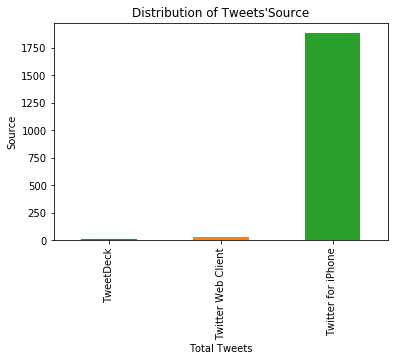

In [438]:
plt.title("Distribution of Tweets'Source")
val = twitter_archive_master.source.value_counts().sort_values()
val.plot(kind ="bar")
plt.xlabel('Total Tweets')
plt.ylabel('Source');


#### an overview about the dataset from these statistics we can see that rating_numerator median is 11 and the values don't a large differ because std is somewhat small

In [439]:
twitter_archive_master.describe()

,rating_numerator,prediction_conf,retweet_count,fav_count
count,1922.000000,1922.000000,1922.000000,1922.000000
mean,11.463424,0.464537,2723.006764,8744.088450
std,40.333073,0.340023,4654.271643,12094.783412
min,0.000000,0.000000,16.000000,81.000000
25%,10.000000,0.139975,618.000000,1896.000000
50%,11.000000,0.457141,1336.500000,4032.000000
75%,12.000000,0.776559,3151.500000,11206.000000
max,1776.000000,0.999956,79515.000000,132810.000000


### **what is the common name of dogs**

Text(0,0.5,'Frequency')

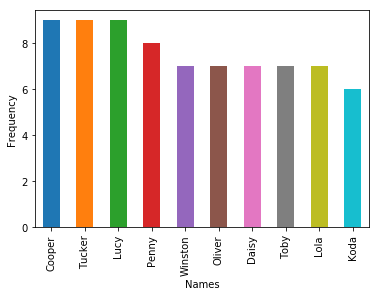

In [440]:
# analyze only named dogs
val = twitter_archive_master.name.value_counts()[1:11].sort_values(ascending=False)
val.plot(kind="bar")
plt.xlabel('Names')
plt.ylabel('Frequency')

### what is the most common breed

Text(0,0.5,'Frequency')

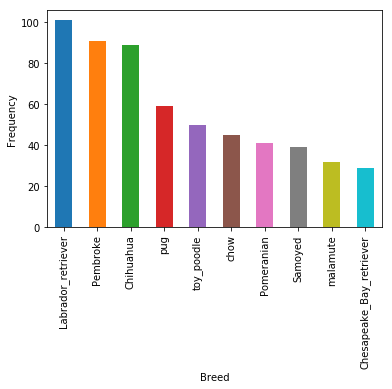

In [441]:
# analyze only named dogs
val = twitter_archive_master.breed.value_counts()[1:11].sort_values(ascending=False)
val.plot(kind="bar")
plt.xlabel('Breed')
plt.ylabel('Frequency')

### what is account statistics 
#### from this analysis we found that account performance and favorit counts are inceasing although retweet counts are decreasing

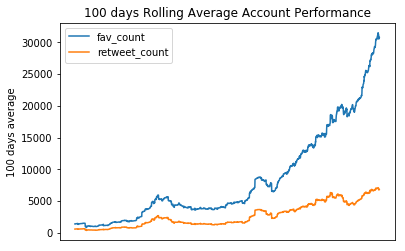

In [442]:
y1= twitter_archive_master.fav_count.rolling(window = 100).mean()
# set a 30 days rolling average for retweet count
y2= twitter_archive_master.retweet_count.rolling(window = 100).mean()
x = twitter_archive_master.timestamp
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.plot(x,y1)
plt.plot(x,y2)
plt.xticks(rotation = 90)
plt.title('100 days Rolling Average Account Performance')
plt.xlabel('Dates')
plt.ylabel('100 days average')
plt.legend(loc=0);

### dog types that a have max rate

In [443]:
twitter_archive_master.groupby(["type"])['rating_numerator','retweet_count','fav_count'].max()[1:]

,rating_numerator,retweet_count,fav_count
type,,,
"doggo, pupper",13.0,17621,44619
floofer,13.0,18497,33345
pupper,14.0,32883,106827
puppo,14.0,48265,132810


### dog types that have min rate

In [444]:
twitter_archive_master.groupby(["type"])['rating_numerator','retweet_count','fav_count'].min()[1:]

,rating_numerator,retweet_count,fav_count
type,,,
"doggo, pupper",5.0,1265,4849
floofer,10.0,496,2262
pupper,3.0,103,693
puppo,9.0,716,3277
